In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick

### Load data

In [2]:
data_dir = "csse_covid_19_data/csse_covid_19_daily_reports/"
data_files = [f for f in os.listdir(data_dir) if f[-4:]==".csv"]
df = pd.concat([pd.read_csv(data_dir + data_file) for data_file in data_files], sort=False)

FileNotFoundError: [Errno 2] No such file or directory: 'csse_covid_19_data/csse_covid_19_daily_reports/'

### Clean location names

In [321]:
df.loc[df["Country/Region"] == "Iran (Islamic Republic of)", "Country/Region"] = "Iran"
df.loc[df["Country/Region"] == "Republic of Korea", "Country/Region"] = "South Korea"
df.loc[df["Country/Region"] == "Korea, South", "Country/Region"] = "South Korea"
df.loc[df["Country/Region"] == "China", "Country/Region"] = "Mainland China"
df.loc[df["Country/Region"] == "UK", "Country/Region"] = "United Kingdom"
df.loc[df["Province/State"] == "UK", "Province/State"] = "United Kingdom"
df.loc[df["Province/State"] == "Diamond Princess", "Province/State"] = "Diamond Princess cruise ship"

na_i = df["Province/State"].isna()
df.loc[na_i, "Province/State"] = df.loc[na_i, "Country/Region"]

### Clean dates

In [322]:
df["Last Update"] = pd.to_datetime(df["Last Update"])
df["Date"] = df["Last Update"].dt.strftime('%y/%m/%d')
df = df.sort_values("Last Update").set_index("Last Update")

### Accumulate incidents, grouped by most granular location

In [323]:
def unq(data):
    return np.unique(data)[0]
def listize(data):
    return list(data)
def cumulative(data):
    cumulative_confirmed = data.fillna(0).cummax()
    return list(cumulative_confirmed.values)

locdf = df.reset_index().groupby("Province/State").agg({
                                                        "Confirmed":cumulative, # listize,
                                                        "Deaths":cumulative,
                                                        "Date":listize,
                                                        "Country/Region":unq,
                                                        "Latitude":unq,
                                                        "Longitude":unq
                                                        })

### Prepare organization of data for presentation

In [324]:
locdf["Current"] = [np.max(x) if len(x) else 0 for x in locdf.Confirmed.values]
locdf["Duration"] = [len(x) for x in locdf.Confirmed.values]
nonchinadf = locdf[locdf["Country/Region"] != "Mainland China"]
usdf = locdf[locdf["Country/Region"] == "US"]

### Plot data

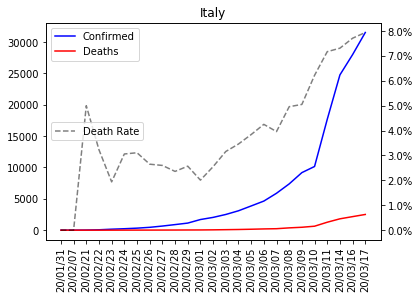

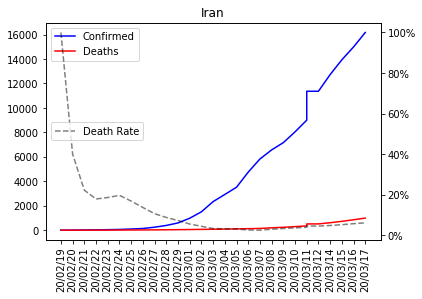

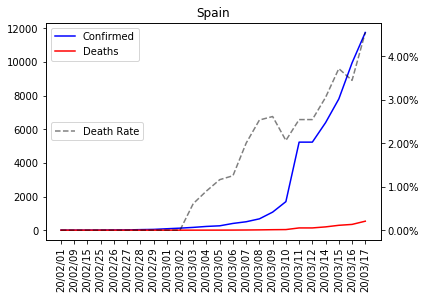

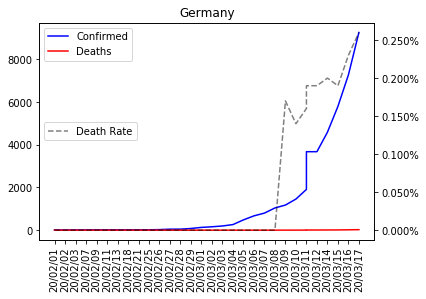

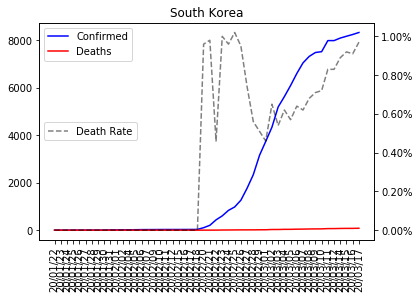

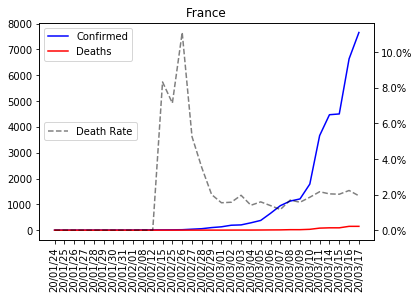

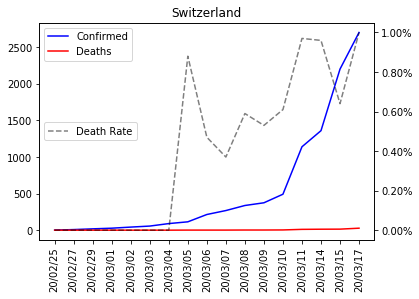

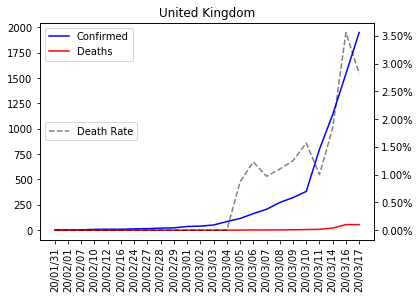

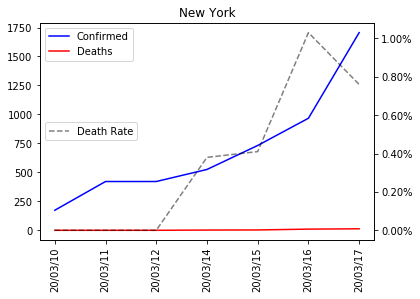

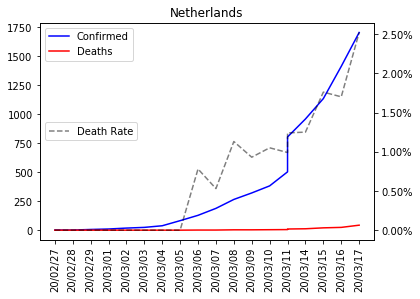

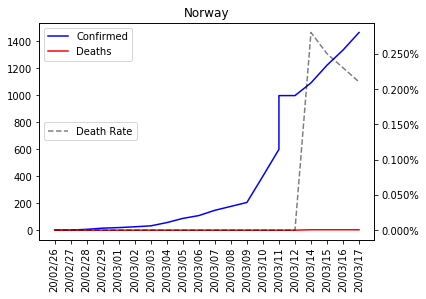

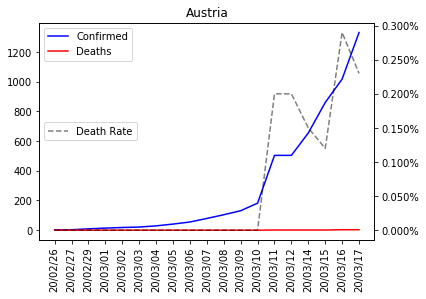

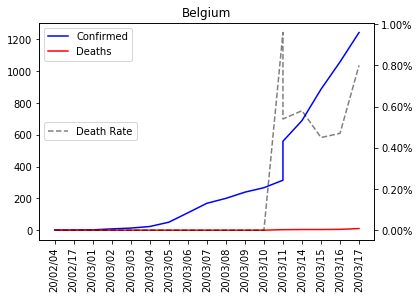

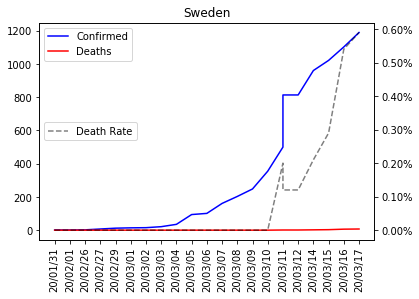

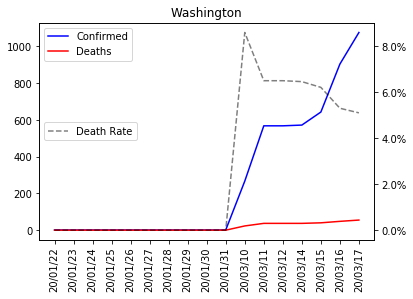

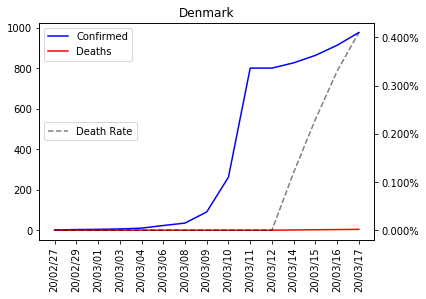

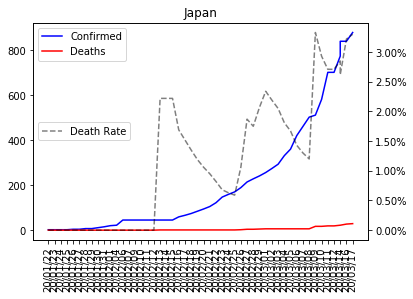

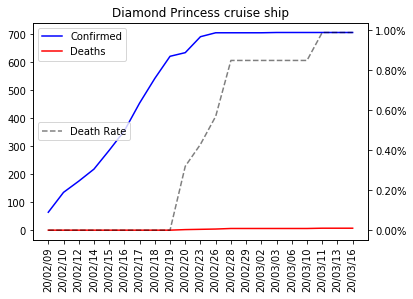

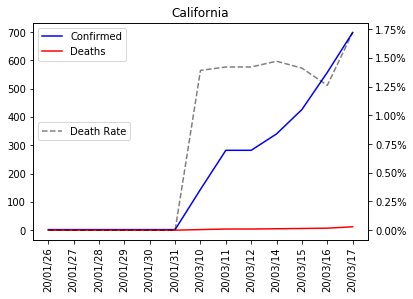

/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


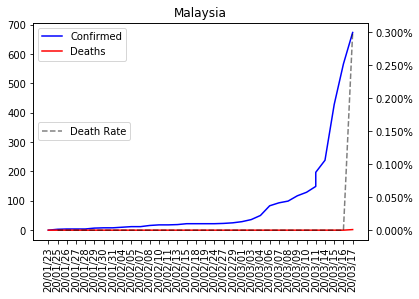

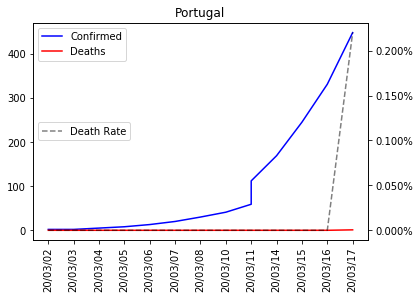

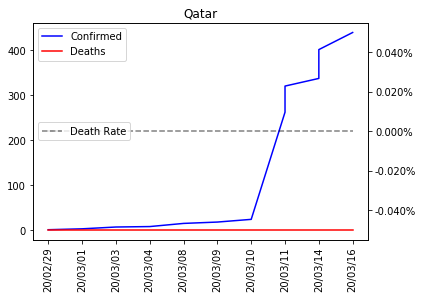

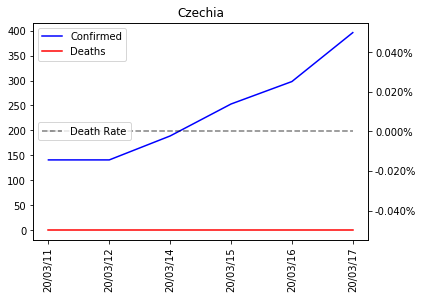

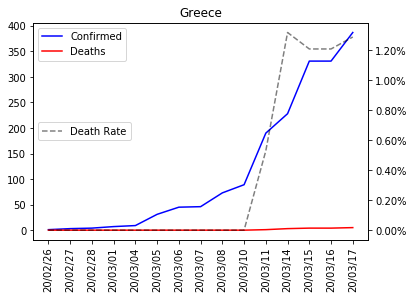

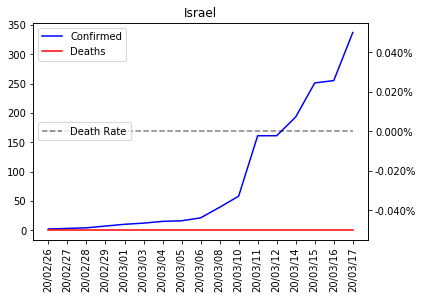

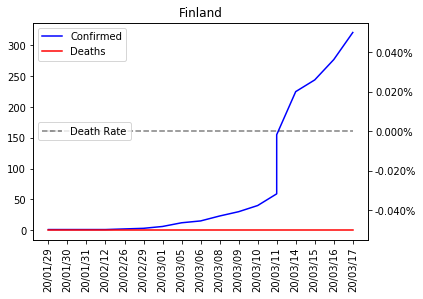

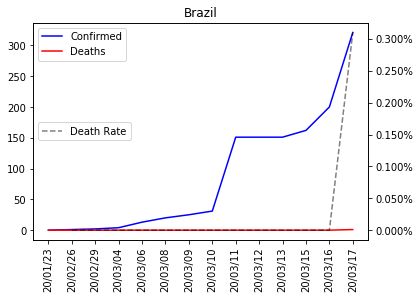

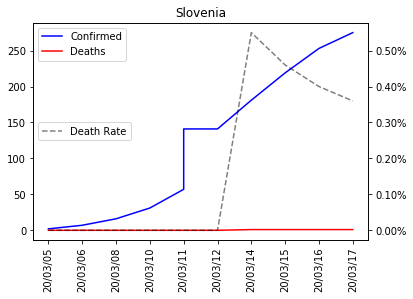

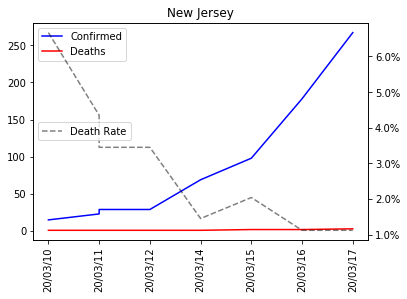

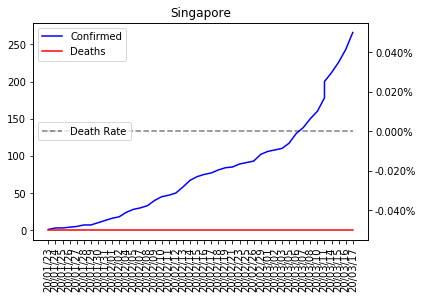

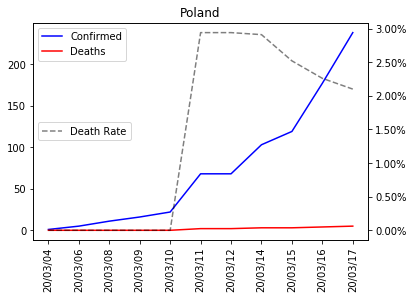

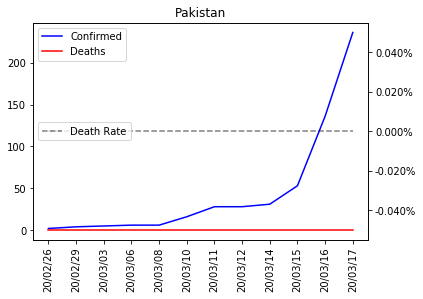

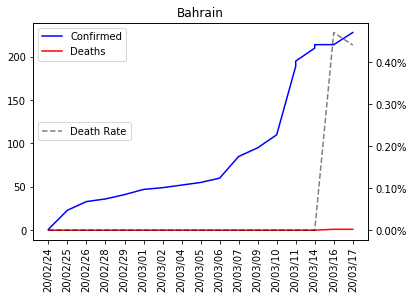

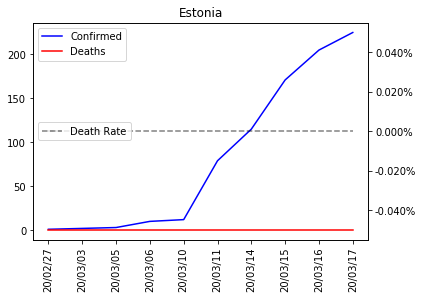

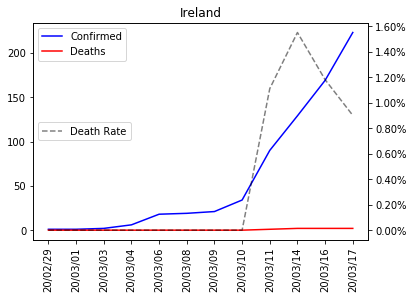

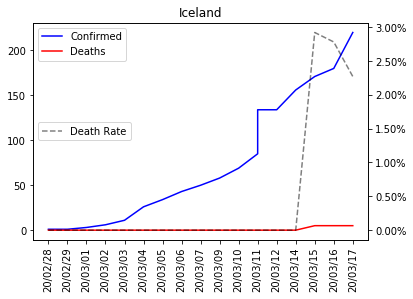

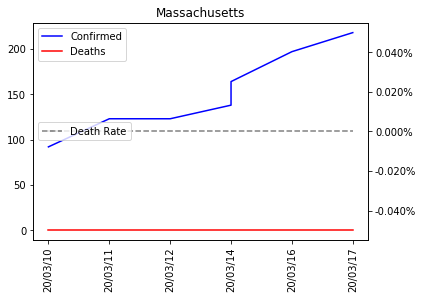

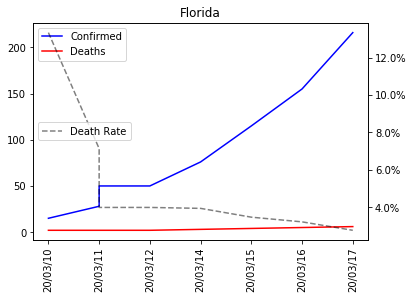

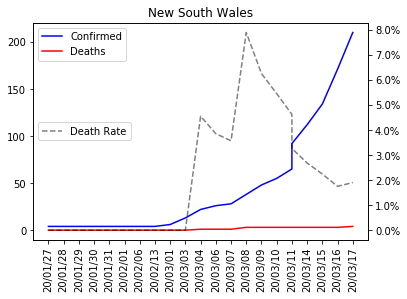

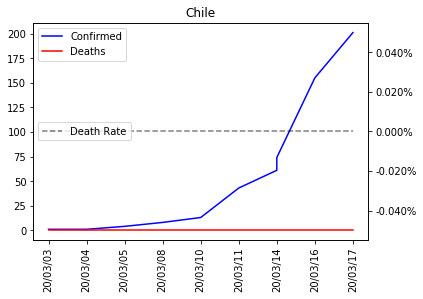

In [327]:
# plotdf = locdf.sort_values("Current", ascending=False) # all locations, ordered by case count
# plotdf = locdf.sort_values("Duration", ascending=False) # all locations, ordered by time since first case
plotdf = nonchinadf.sort_values("Current", ascending=False) # non-China locations, ordered by case count
# plotdf = usdf.sort_values("Current", ascending=False) # US locations, ordered by case count
for index, row in plotdf.iloc[:40].iterrows():
    fig, ax = plt.subplots()
    plt.xticks(rotation=90)
    ax.plot(row["Date"], row["Confirmed"], "b")
    ax.plot(row["Date"], row["Deaths"], "r")
    ax2 = ax.twinx()
    ax2.yaxis.set_major_formatter(mtick.PercentFormatter())
    death_rate = np.round(np.array(row["Deaths"]) / np.array(row["Confirmed"]) * 100, 2)
    ax2.plot(row["Date"], death_rate, "k--", alpha=0.5)
    ax.legend(["Confirmed", "Deaths"], loc="upper left")
    ax2.legend(["Death Rate"], loc="center left")
    plt.title(index)
    plt.show()